In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [3]:
aaa = pd.read_csv("/data2/cehou/LLM_safety/Stockholm/safety_score.csv")

In [9]:
aaa.rename(columns={"panoid":"Image_ID"},inplace=True)

In [ ]:
aaa.to_csv("/data2/cehou/LLM_safety/Stockholm/safety_score.csv", index=False)

In [3]:
file_path = "/data2/cehou/LLM_safety/Stockholm/safety_ai.csv"
safety_score = pd.read_csv(file_path)
safety_score = safety_score.drop(index=0).reset_index(drop=True)
safety_score['winner'] = safety_score.apply(lambda x: x['ImageID_A'] if x['Safe_Unsafe'] == "Trygg" else x['ImageID_B'], axis=1)
safety_score['loser'] = safety_score.apply(lambda x: x['ImageID_A'] if x['Safe_Unsafe'] == "Otrygg" else x['ImageID_B'], axis=1)

<Axes: ylabel='Frequency'>

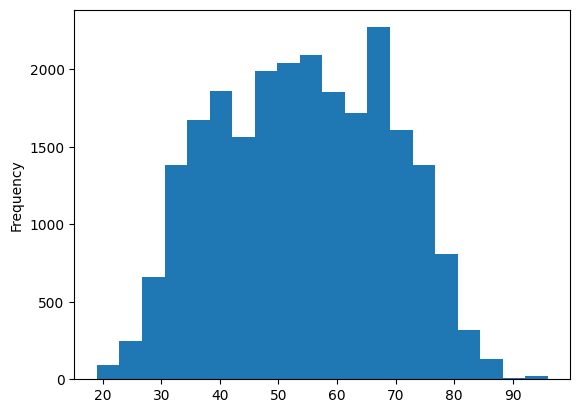

In [53]:
safety_score['Panel Member_Age'].astype(int).plot(kind='hist', bins=20)

In [4]:
img_all_idx = safety_score['ImageID_B'].value_counts().index.tolist() + safety_score['ImageID_A'].value_counts().index.tolist()
img_all_idx = set(img_all_idx)

In [5]:
def cal_safety_score(safety_score, img_id):
    all_img = safety_score[(safety_score['ImageID_A'] == img_id) | (safety_score['ImageID_B'] == img_id)]
    p_i = all_img[all_img['winner'] == img_id]['winner'].count()
    n_i = all_img[all_img['winner'] != img_id]['winner'].count()
    positive_rate = p_i / all_img['winner'].count()
    negative_rate = n_i / all_img['winner'].count()
    # print("positive rate: ", positive_rate)
    # print("negative rate: ", negative_rate)
    # safety_score_value = 10/3 * (positive_rate + positive_rate/p_i - negative_rate/n_i + 1)
    return p_i, n_i, positive_rate, negative_rate

In [6]:
img_id = "2426"
p_i, n_i, positive_rate, negative_rate = cal_safety_score(safety_score, img_id)
all_img = safety_score[(safety_score['ImageID_A'] == img_id) | (safety_score['ImageID_B'] == img_id)]
sub_negative_rate_ls = []
sub_positive_rate_ls = []

for i, row in all_img.iterrows():
    if row['winner'] == img_id: # winner
        _, _, _, sub_positive_rate = cal_safety_score(safety_score, row['loser'])
        sub_positive_rate_ls.append(sub_positive_rate)
    else: # loser
        _, _, sub_negative_rate, _ = cal_safety_score(safety_score, row['winner'])
        sub_negative_rate_ls.append(sub_negative_rate)

score = 10/3 * (positive_rate + sum(sub_positive_rate_ls)/p_i - sum(sub_negative_rate_ls)/n_i + 1)

In [7]:
img_id = "4628"
safety_score[(safety_score['ImageID_A'] == img_id) | (safety_score['ImageID_B'] == img_id)]

,ExternalReferenceID.a.1,Safe_Unsafe,ImageID_A,Region Image_A,ImageID_B,Region Image_B,Panel Member_Gender,Panel Member_Age,Panel Member_Household_children,Panel Member_Household_Living_Alone,Panel Member_Household_Moveto_Date,PostalCode,Collectionarea_type,Nyckelkod_Basområde,winner,loser
24,36c566f3-0ad4-463e-64d6-f6437a123ac9,Otrygg,4628,3,4634,3,Kvinna,79,NaN,"Nej, bara jag bor i hushållet",1990 – 1999,11738,1,1420140,4634,4628
2618,1fae3457-e150-44cb-ae9b-bf13019408c6,Otrygg,4628,3,2944,3,Kvinna,39,"Ja, barn/Ungdomar",NaN,2017 – 2018,11348,1,1110230,2944,4628
6897,687cb090-8d99-4368-9f04-c016ad723d1b,Trygg,4151,2,4628,2,Man,52,"Ja, barn/Ungdomar",NaN,2000 – 2004,16246,2,2230200,4151,4628
13046,573b9b49-c5af-4534-1c86-11d6832987be,Otrygg,4628,3,206,3,Man,64,NaN,NaN,Tidigare än 1990,12574,1,2121021,206,4628
14546,12da67b7-65aa-4184-16fa-fa6f0c29f042,Trygg,4766,6,4628,6,Man,67,NaN,"Nej, bara jag bor i hushållet",2000 – 2004,12653,3,2110130,4766,4628
18344,D763A5D6-C247-7345-BDD2-8C3F36AFA083,Otrygg,4628,4,2904,4,Kvinna,70,NaN,"Nej, bara jag bor i hushållet",Tidigare än 1990,12838,5,2150720,2904,4628


In [8]:
p_i, n_i, positive_rate, negative_rate = cal_safety_score(safety_score, "4628")
p_i, n_i, positive_rate, negative_rate

(0, 6, 0.0, 1.0)

In [9]:
img_id = "4628"
p_i, n_i, positive_rate, negative_rate = cal_safety_score(safety_score, img_id)
all_img = safety_score[(safety_score['ImageID_A'] == img_id) | (safety_score['ImageID_B'] == img_id)]
sub_negative_rate_ls = []
sub_positive_rate_ls = []

for i, row in all_img.iterrows():
    if row['winner'] == img_id: # winner
        _, _, _, sub_positive_rate = cal_safety_score(safety_score, row['loser'])
        sub_positive_rate_ls.append(sub_positive_rate)
    else: # loser
        _, _, sub_negative_rate, _ = cal_safety_score(safety_score, row['winner'])
        sub_negative_rate_ls.append(sub_negative_rate)



In [10]:
# calculate positive rate and negative rate
# otrygg - unsafe, trygg - safe
safety_score_value_ls = []
for img_id in tqdm(img_all_idx):
    p_i, n_i, positive_rate, negative_rate = cal_safety_score(safety_score, img_id)
    all_img = safety_score[(safety_score['ImageID_A'] == img_id) | (safety_score['ImageID_B'] == img_id)]
    sub_negative_rate_ls = []
    sub_positive_rate_ls = []
    for i, row in all_img.iterrows():
        if row['winner'] == img_id: # winner
            _, _, _, sub_positive_rate = cal_safety_score(safety_score, row['loser'])
            sub_positive_rate_ls.append(sub_positive_rate)
        else: # loser
            _, _, sub_negative_rate, _ = cal_safety_score(safety_score, row['winner'])
            sub_negative_rate_ls.append(sub_negative_rate)

    if p_i == 0:
        score = 10/3 * (positive_rate - sum(sub_negative_rate_ls)/n_i + 1)
    elif n_i == 0:
        score = 10/3 * (positive_rate + sum(sub_positive_rate_ls)/p_i + 1)
    else:
        score = 10/3 * (positive_rate + sum(sub_positive_rate_ls)/p_i - sum(sub_negative_rate_ls)/n_i + 1)
        
    safety_score_value_ls.append([img_id, score])

# img_id = str(535)
# all_img = safety_score[(safety_score['ImageID_A'] == img_id) | (safety_score['ImageID_B'] == img_id)]

  0%|          | 0/4953 [00:00<?, ?it/s]

  1%|          | 31/4953 [00:00<02:35, 31.57it/s]


KeyboardInterrupt: 

In [65]:
safety_score

,ExternalReferenceID.a.1,Safe_Unsafe,ImageID_A,Region Image_A,ImageID_B,Region Image_B,Panel Member_Gender,Panel Member_Age,Panel Member_Household_children,Panel Member_Household_Living_Alone,Panel Member_Household_Moveto_Date,PostalCode,Collectionarea_type,Nyckelkod_Basområde,winner,loser
0,4802161b-b84c-48e1-ac6f-4e3f2edc8038,Otrygg,535,4,167,4,Man,44,NaN,"Nej, bara jag bor i hushållet",2015 – 2016,12346,4,2160330,167,535
1,ff56439d-67da-435b-d2c8-c024a9bc7a44,Trygg,3418,5,4301,5,Kvinna,72,NaN,"Nej, bara jag bor i hushållet",Tidigare än 1990,11221,1,1310110,3418,4301
2,8dc34ef4-c98b-483b-4b64-f0ad2281f848,Trygg,1974,5,523,5,Man,71,NaN,NaN,2010 – 2014,11545,1,1210422,1974,523
3,5f19fc8e-4132-4d62-267e-09d410c1ccb8,Trygg,896,5,1755,5,Kvinna,60,NaN,NaN,2019 eller senare,11427,1,1210120,896,1755
4,8ccb19d1-7671-4192-cca0-a09df107f368,Trygg,4886,4,2310,4,Kvinna,77,NaN,"Nej, bara jag bor i hushållet",Tidigare än 1990,12639,4,2120620,4886,2310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23705,b700aa39-7357-475c-0906-7d372c4bcf58,Trygg,13,2,2110,2,Kvinna,57,NaN,NaN,2010 – 2014,12761,2,2170120,13,2110
23706,4fa45def-8517-417d-0774-175d3b9fd54e,Trygg,3684,1,240,1,Kvinna,72,NaN,"Nej, bara jag bor i hushållet",2010 – 2014,16355,5,2240650,3684,240
23707,9861e81a-2820-4802-0e6f-6c701ccfafc1,Otrygg,2011,4,1438,4,Kvinna,43,"Ja, barn/Ungdomar",NaN,2015 – 2016,11759,1,2110681,1438,2011
23708,5346826d-52b4-4c29-102f-dcfbcaeb5b01,Otrygg,938,1,4449,1,Kvinna,65,NaN,NaN,2000 – 2004,16565,5,2250332,4449,938


In [55]:
safety_score_value_df = pd.DataFrame(safety_score_value_ls, columns=['winner', 'Safety_Score'])

<Axes: ylabel='Frequency'>

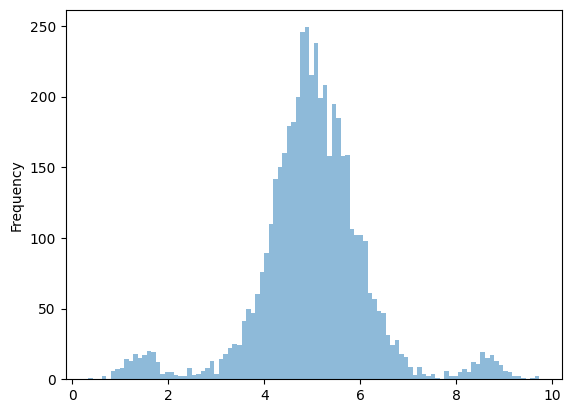

In [48]:
img_hash['Safety_Score'].plot.hist(bins=100, alpha=0.5)


In [49]:
from scipy.stats import norm

# 拟合正态分布
mu, std = norm.fit(img_hash['Safety_Score'])

# 输出均值和标准差
print(f"Mean: {mu}, Standard Deviation: {std}")

Mean: 5.005035779353291, Standard Deviation: 1.1946622922633925


In [69]:
img_hash_path = "/data2/cehou/LLM_safety/Stockholm/FileIndex5000.xlsx"
img_hash = pd.read_excel(img_hash_path)
safety_score_value_df['winner'] = safety_score_value_df['winner'].astype(int)

In [80]:
img_hash = img_hash.merge(safety_score_value_df, left_on='ID', right_on='winner', how='left')

In [93]:
img_hash.to_csv("/data2/cehou/LLM_safety/Stockholm/safety_score.csv", index=False)

In [44]:
img_hash = pd.read_csv("/data2/cehou/LLM_safety/Stockholm/safety_score.csv")

In [46]:
img_hash

,ID,URL,panoid,winner,Safety_Score
0,1,7CXjLkPOAR3/zzcn_7ZfSJioXBih4kuKfA_180.jpg,zzcn_7ZfSJioXBih4kuKfA_180,1,4.418562
1,2,JVBzES9Ado/zYO_pdC_oA9yk0gewKDJ3A_0.jpg,zYO_pdC_oA9yk0gewKDJ3A_0,2,4.521329
2,3,3bHFyoMf6Zb/ZYNBrgLMfB2TsuDR5sTv3Q_90.jpg,ZYNBrgLMfB2TsuDR5sTv3Q_90,3,4.885076
3,4,8IlhXZKbIJA/ZYaSZs2K6bji78qt85XAgg_0.jpg,ZYaSZs2K6bji78qt85XAgg_0,4,5.376107
4,5,7bxTJBXa7sj/zY2OFuTYvuteu4yQ-SHg3A_90.jpg,zY2OFuTYvuteu4yQ-SHg3A_90,5,3.375842
...,...,...,...,...,...
4926,4949,TZmQs4WYiU/Aa4KHKuEvOs7k5xEK5VpTg_0.jpg,Aa4KHKuEvOs7k5xEK5VpTg_0,4949,5.685740
4927,4950,2zM7zByugOZ/ZzY-gVH3Lr19gW049IdYaQ_0.jpg,ZzY-gVH3Lr19gW049IdYaQ_0,4950,3.727411
4928,4951,3QqRLuI1IZZ/ZzwKHC8_l21dvQBg93Hq3g_270.jpg,ZzwKHC8_l21dvQBg93Hq3g_270,4951,5.078471
4929,4952,4ZHDtHzNA1K/ZzuG4Oz0IM0USLWG4R1EGg_0.jpg,ZzuG4Oz0IM0USLWG4R1EGg_0,4952,6.093534
